# Final Project: Predicting International Football Match Outcomes

**Group Members:** Abdussalam Raheem, Jacob Joseph, Anuraag Deepak

This notebook presents a complete data analysis workflow to predict the outcome of men's international football matches. We will clean and prepare historical match data, engineer predictive features, train and evaluate multiple machine learning models, and interpret the results to uncover the key factors driving match outcomes.

## 1. Defining the Question(s)

### Central Goal  
Can we build and evaluate a machine learning model that accurately predict the outcome of a men's international football match (Home Win, Draw, or Away Win) using historical match data?

### Secondary Questions  
- What features matter most for predicting match outcomes? (e.g., recent form, historical dominance, home-field advantage)  
- Does model performance change across tournament types (World Cup vs. friendlies)?  
- Does the model show any bias, such as favoring top-ranked teams over underdogs?

## 2. Data Collection

We will utilize the "International football results from 1872 to 2022" dataset, sourced from Kaggle. The project uses the primary `results.csv` file, which contains match details from 1872 to the present. The data is limited to men's senior international matches, ensuring a consistent scope for our analysis.

### Import necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


#Modeling Imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Using imblearn to handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE


### Load the Datasets

In [4]:
results = pd.read_csv('data/results.csv')
goalscorers = pd.read_csv('data/goalscorers.csv')
shootouts = pd.read_csv('data/shootouts.csv')
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


## 3. Data Cleaning and Preparation

This phase is critical for the model's success. We will perform the following steps:
1.  Load the data and perform foundational cleaning, including converting data types.
2.  **Crucially, we sort the data chronologically by date.** This is essential to prevent data leakage and ensure our feature engineering is logically sound.
3.  Create the `outcome` target variable.
4.  Engineer predictive features that quantify a team's strength and form *at the time of each match*. This includes rolling form metrics and head-to-head records.

In [5]:
# Date and year extracted from date column
results['date'] = pd.to_datetime(results['date'])
results['year'] = results['date'].dt.year

# Sort the DataFrame chronologically. This prevents data leakage in feature engineering.
results = results.sort_values('date').reset_index(drop=True)

# Determine match outcome by comparing scores
def get_outcome(row):
    if row['home_score'] > row['away_score']:
        return "Home Win"
    elif row['away_score'] > row['home_score']:
        return "Away Win"
    else:
        return "Draw"
    
# Convert False to 0 and True to 1 on neutral column
def is_neutral(row):
    if row['neutral']:
        return 1
    else:
        return 0
        
results['outcome'] = results.apply(get_outcome, axis=1)
results['neutral'] = results.apply(is_neutral, axis=1)

print(results.tail(10))
print(results.info())

            date     home_team        away_team  home_score  away_score  \
48840 2025-11-18         Yemen           Bhutan         7.0         1.0   
48841 2025-11-18        Brunei          Lebanon         0.0         3.0   
48842 2025-11-18    Bangladesh            India         1.0         0.0   
48843 2025-11-18     Hong Kong        Singapore         1.0         2.0   
48844 2025-11-18     Sri Lanka         Thailand         0.0         4.0   
48845 2025-11-18  Turkmenistan           Taiwan         3.0         1.0   
48846 2025-11-18        Kuwait           Gambia         2.0         2.0   
48847 2025-11-18          Iran       Uzbekistan         0.0         0.0   
48848 2025-11-19          Laos          Vietnam         0.0         2.0   
48849 2025-11-20       Vanuatu  Solomon Islands         NaN         NaN   

                        tournament                 city               country  \
48840  AFC Asian Cup qualification          Kuwait City                Kuwait   
48841  AFC A

In this section, the goal is to build useful features that can help predict the outcome of each match. To do this, we first create a function that pulls all previous games played by a team—both home and away—before the current match date. This gives us a complete picture of how each team has been performing leading up to the game.

We also create a small helper function that assigns points based on whether a team won, lost, or drew. Using these functions, we generate two data frames for every match: one showing the home team’s recent games and another showing the away team’s recent games.

From these histories, we calculate simple performance stats such as the average goals a team scores, the average goals they allow, and the average points they earn over their last few games. If a team doesn’t have enough prior matches, we fill in any missing values with zeros so the data stays consistent.

Lastly, we add all these rolling performance metrics back into our main dataset as new columns, giving the model richer information about each team’s form heading into every match.

In [6]:
# Nummer of missing values in each column
# Function to filter games played by a particular team and game date
def filter_games_by_team(team_name, game_date):
    home_games = results[(results["home_team"] == team_name) & (results["date"] < game_date)]
    away_games = results[(results["away_team"] == team_name) & (results["date"] < game_date)]
    return pd.concat([home_games, away_games]).sort_values('date')
        
# Function to allocate points to Home team for win, lost or draw
def get_points_from_outcome(team_name, outcome, home_team, away_team):
    """Helper function to assign points based on match outcome."""
    if (team_name == home_team and outcome == 'Home Win') or (team_name == away_team and outcome == 'Away Win'):
        return 3
    elif outcome == 'Draw':
        return 1
    else:
        return 0

# Function to calculate average scores based on certain metrics
def calculate_rolling_form_metrics(row, N=10):
    """
    Calculates rolling averages for goals, conceded goals, and points for each team.
    """
    home_team = row['home_team']
    away_team = row['away_team']
    game_date = row['date']

    home_history = filter_games_by_team(home_team, game_date).tail(N)
    away_history = filter_games_by_team(away_team, game_date).tail(N)

    # --- Home Team Metrics ---
    if home_history.empty:
        # If there's no history, all metrics are 0
        home_goals_scored = 0
        home_goals_conceded = 0
        home_points = 0
    else:
        # If history exists, calculate the means
        home_goals_scored = np.where(home_history['home_team'] == home_team, home_history['home_score'], home_history['away_score']).mean()
        home_goals_conceded = np.where(home_history['home_team'] == home_team, home_history['away_score'], home_history['home_score']).mean()
        home_points = home_history.apply(lambda r: get_points_from_outcome(home_team, r['outcome'], r['home_team'], r['away_team']), axis=1).mean()

    # --- Away Team Metrics ---
    if away_history.empty:
        # If there's no history, all metrics are 0
        away_goals_scored = 0
        away_goals_conceded = 0
        away_points = 0
    else:
        # If history exists, calculate the means
        away_goals_scored = np.where(away_history['home_team'] == away_team, away_history['home_score'], away_history['away_score']).mean()
        away_goals_conceded = np.where(away_history['home_team'] == away_team, away_history['away_score'], away_history['home_score']).mean()
        away_points = away_history.apply(lambda r: get_points_from_outcome(away_team, r['outcome'], r['home_team'], r['away_team']), axis=1).mean()

    metrics = [
        home_goals_scored, home_goals_conceded, home_points,
        away_goals_scored, away_goals_conceded, away_points
    ]

    # Now we just return the list directly, no .fillna() needed as we handled the empty case.
    return metrics

def calculate_h2h_home_win_pct(row):
    """Calculates the historical home win percentage for a specific matchup."""
    past_matches = results[
        (results['home_team'] == row['home_team']) &
        (results['away_team'] == row['away_team']) &
        (results['date'] < row['date'])
    ]
    if len(past_matches) > 0:
        home_wins = sum(past_matches['outcome'] == 'Home Win')
        return home_wins / len(past_matches)
    else:
        return 0.50 # Default to 0.5 if no prior matchups
    
rolling_form_columns = [
    'avg_goals_scored_home_team',
    'avg_goals_conceded_home_team',
    'avg_points_home_team',
    'avg_goals_scored_away_team',
    'avg_goals_conceded_away_team',
    'avg_points_away_team'
]
results[rolling_form_columns] = results.apply(calculate_rolling_form_metrics, axis=1, result_type='expand')
results['h2h_home_win_pct'] = results.apply(calculate_h2h_home_win_pct, axis=1)

results["goal_difference_form"] = results["avg_goals_scored_home_team"] - results["avg_goals_scored_away_team"]
results["points_difference_form"] = results["avg_points_home_team"] - results["avg_points_away_team"]

display(results[['date', 'home_team', 'away_team', 'points_difference_form', 'h2h_home_win_pct']].tail())

C:\Users\abdus\AppData\Local\Temp\ipykernel_42972\1101376568.py:28: RuntimeWarning: Mean of empty slice.
  home_goals_scored = np.where(home_history['home_team'] == home_team, home_history['home_score'], home_history['away_score']).mean()
c:\Users\abdus\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\abdus\AppData\Local\Temp\ipykernel_42972\1101376568.py:29: RuntimeWarning: Mean of empty slice.
  home_goals_conceded = np.where(home_history['home_team'] == home_team, home_history['away_score'], home_history['home_score']).mean()
C:\Users\abdus\AppData\Local\Temp\ipykernel_42972\1101376568.py:33: RuntimeWarning: Mean of empty slice.
  away_goals_scored = np.where(away_history['home_team'] == away_team, away_history['home_score'], away_history['away_score']).mean()
c:\Users\abdus\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered i

,date,home_team,away_team,points_difference_form,h2h_home_win_pct
48845,2025-11-18,Turkmenistan,Taiwan,0.5,1.000
48846,2025-11-18,Kuwait,Gambia,-0.9,0.500
48847,2025-11-18,Iran,Uzbekistan,0.2,0.500
48848,2025-11-19,Laos,Vietnam,-2.1,0.000
48849,2025-11-20,Vanuatu,Solomon Islands,0.4,0.375


In [8]:
print(results.tail(10).describe().to_string())

                      date  home_score  away_score    neutral    year  avg_goals_scored_home_team  avg_goals_conceded_home_team  avg_points_home_team  avg_goals_scored_away_team  avg_goals_conceded_away_team  avg_points_away_team  h2h_home_win_pct  goal_difference_form  points_difference_form
count                   10    9.000000    9.000000  10.000000    10.0                   10.000000                     10.000000             10.000000                   10.000000                     10.000000             10.000000         10.000000             10.000000               10.000000
mean   2025-11-18 07:12:00    1.555556    1.666667   0.400000  2025.0                    1.350000                      1.590000              1.260000                    1.540000                      1.370000              1.420000          0.439722             -0.190000               -0.160000
min    2025-11-18 00:00:00    0.000000    0.000000   0.000000  2025.0                    0.700000                     

In [9]:
print(results['h2h_home_win_pct'])
print(results['goal_difference_form'])

0        0.500
1        0.500
2        0.000
3        1.000
4        0.500
         ...  
48845    1.000
48846    0.500
48847    0.500
48848    0.000
48849    0.375
Name: h2h_home_win_pct, Length: 48850, dtype: float64
0        0.000000
1        0.000000
2       -1.000000
3        0.333333
4       -0.250000
           ...   
48845   -0.400000
48846   -1.200000
48847    0.600000
48848   -1.400000
48849    0.100000
Name: goal_difference_form, Length: 48850, dtype: float64


## 4. Data Analysis

With our features engineered, we now proceed with the analysis. This includes:
1.  **Exploratory Data Analysis (EDA):** Visualizing key trends and distributions in the data.
2.  **Data Splitting:** Dividing our data into training and testing sets chronologically.
3.  **Handling Class Imbalance:** Using SMOTE to address the under-representation of 'Draw' outcomes.
4.  **Modeling with Cross-Validation:** Training and evaluating our models using a robust resampling procedure.

Data analysis is done first looking at the frequency of outcomes in our dataframe results as a bar chart. It is inferred the home wins dominate our data.

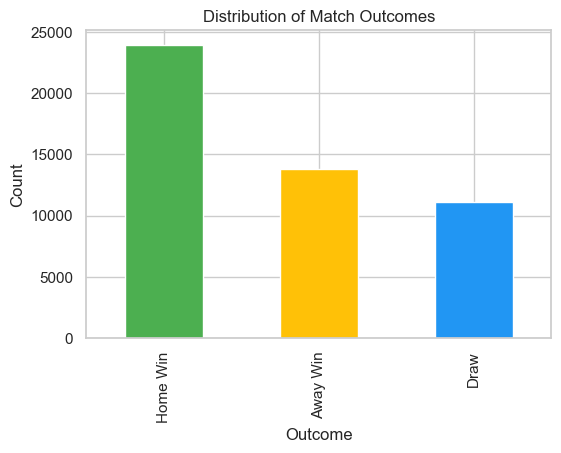

In [12]:
# 1. Bar Chart showing the distribution of outcomes

sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
results['outcome'].value_counts().plot(kind='bar', color=['#4CAF50','#FFC107','#2196F3'])
plt.title('Distribution of Match Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Next we analyze the average Goals per match counted every 10 years using a line plot. It is inferred that with time the matches are getting competetive that the average goals scored decreases.

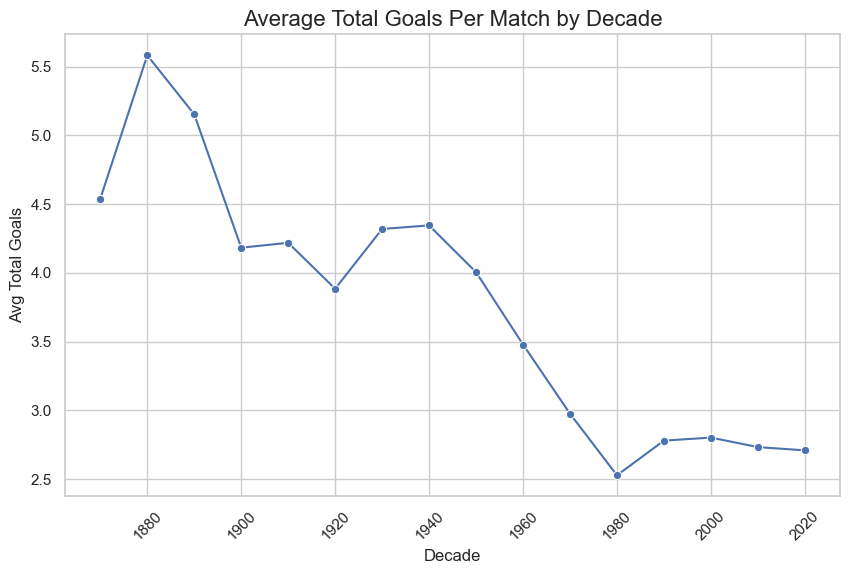

In [13]:
# 2. Average Goals Per Match By Decade
results['decade'] = (results['year'] // 10) * 10
decade_goals = results.groupby('decade')[['home_score', 'away_score']].mean().sum(axis=1)

plt.figure(figsize=(10, 6))
sns.lineplot(x=decade_goals.index, y=decade_goals.values, marker='o')
plt.title('Average Total Goals Per Match by Decade', fontsize=16)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Avg Total Goals", fontsize=12)
plt.xticks(rotation=45)
plt.show()

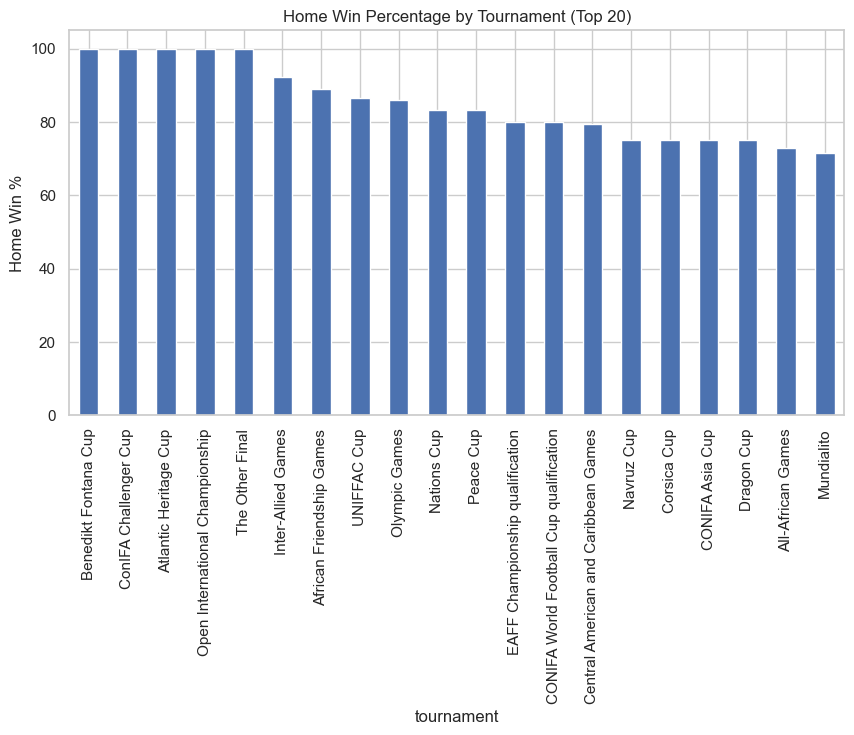

In [14]:
# 3. Home Win % by Tournament

tournament_home_win_pct = (
    (results['outcome'] == 'Home Win')
    .groupby(results['tournament'])
    .mean()
    .sort_values(ascending=False)
    * 100
)

plt.figure(figsize=(10,5))
tournament_home_win_pct.head(20).plot(kind='bar')
plt.title("Home Win Percentage by Tournament (Top 20)")
plt.ylabel("Home Win %")
plt.show()

###Preparing Dependent and Independent variables for modeling the DataFrame

Here we work on defining varaiables and grouping them to use them for prediction based analysis using models. A dataframe "results_sorted" is created to hold the results data sorted datewise. We pass on the metrics we created earlier as "features" and use them as Independent variable under X. The "outcome" is the depependent variable. The dataset is then split based on a date to keep roughly 80% of the data under a training dataset and 20% under test dataset.

In [15]:
# Define the features we will use for prediction
features = [
    'neutral',
    # Rolling form features
    'avg_goals_scored_home_team', 
    'avg_goals_conceded_home_team', 
    'avg_points_home_team',
    'avg_goals_scored_away_team', 
    'avg_goals_conceded_away_team', 
    'avg_points_away_team',
    # Form difference features
    'goal_difference_form',
    'points_difference_form',
    # Head-to-head
    'h2h_home_win_pct',
    
]

# Define the target variable
target = 'outcome'

#already sorted this earlier so no need to resort again
# We train on past data to predict future data.
split_date = "2018-01-01"
train_idx = results['date'] < split_date
test_idx = results['date'] >= split_date

X_train = results.loc[train_idx, features]
X_test = results.loc[test_idx, features]
y_train = results.loc[train_idx, target]
y_test = results.loc[test_idx, target]

# Encode the categorical target variable ('Away Win', 'Draw', 'Home Win') into numbers (0, 1, 2)
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("\nLabel Encoding Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} -> {i}")

Training set size: 41257
Test set size: 7593

Label Encoding Mapping:
Away Win -> 0
Draw -> 1
Home Win -> 2


In [16]:
# --- Handling Class Imbalance with SMOTE ---

# Our EDA showed a significant imbalance; 'Draw' is a minority class.
# Models often struggle to predict minority classes. We use SMOTE (Synthetic Minority Over-sampling Technique)
# to create synthetic 'Draw' examples in our training data to help the model learn.

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote_enc = smote.fit_resample(X_train, y_train_enc)

# Check the new class distribution to confirm SMOTE worked.
print("Original training distribution (Away Win, Draw, Home Win):", np.bincount(y_train_enc))
print("SMOTE-resampled training distribution:", np.bincount(y_train_smote_enc))

Original training distribution (Away Win, Draw, Home Win): [11580  9358 20319]
SMOTE-resampled training distribution: [20319 20319 20319]


4. Baseline model using Dummy Classifier
We use a generic dummy classifier and see how the model was able to classify the data. The accuracy of prediction is around 47.5%

In [18]:
# This model always predicts the most frequent class. Its accuracy is our baseline to beat.
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train_enc)
baseline_pred = baseline.predict(X_test)
baseline_acc = accuracy_score(y_test_enc, baseline_pred)

print("Baseline Accuracy:", baseline_acc)

Baseline Accuracy: 0.4782036085868563


In [20]:
print(X_train.describe())
print(X_train.head())
print(X_train.isna().sum())

            neutral  avg_goals_scored_home_team  avg_goals_conceded_home_team  \
count  41257.000000                41257.000000                  41257.000000   
mean       0.254381                    1.501954                      1.481341   
std        0.435518                    0.760970                      0.934076   
min        0.000000                    0.000000                      0.000000   
25%        0.000000                    1.000000                      0.900000   
50%        0.000000                    1.400000                      1.300000   
75%        1.000000                    1.900000                      1.800000   
max        1.000000                   19.000000                     24.000000   

       avg_points_home_team  avg_goals_scored_away_team  \
count          41257.000000                41257.000000   
mean               1.391357                    1.476339   
std                0.590416                    0.749884   
min                0.000000       

In [21]:
# --- Modeling with Cross-Validation ---
# We will use k-fold cross-validation on our training data to get a robust estimate of model performance.

# Define the k-fold cross-validation strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)


# 1. Logistic Regression Model with Cross-Validation on SMOTE data
print("--- Training Logistic Regression ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
cv_scores_lr = cross_val_score(log_reg, X_train_smote, y_train_smote_enc, cv=cv_strategy, scoring='accuracy')
print(f"Logistic Regression CV Accuracy (with SMOTE): {np.mean(cv_scores_lr):.4f} (+/- {np.std(cv_scores_lr):.4f})\n")

# 3. Random Forest Model with Cross-Validation on SMOTE data
print("--- Training Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
cv_scores_rf = cross_val_score(rf, X_train_smote, y_train_smote_enc, cv=cv_strategy, scoring='accuracy')
print(f"Random Forest CV Accuracy (with SMOTE): {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf):.4f})")


--- Training Logistic Regression ---
Logistic Regression CV Accuracy (with SMOTE): 0.4778 (+/- 0.0063)

--- Training Random Forest ---
Random Forest CV Accuracy (with SMOTE): 0.5499 (+/- 0.0022)


In [ ]:
print("--- Training Gradient Boosting ---")


gb = GradientBoostingClassifier(random_state=42)
cv_scores_gb = cross_val_score(gb, X_train_smote, y_train_smote_enc,
                               cv=cv_strategy, scoring='accuracy')
print(f"Gradient Boosting CV Accuracy (with SMOTE): {np.mean(cv_scores_gb):.4f} (+/- {np.std(cv_scores_gb):.4f})\n")

--- Training Gradient Boosting ---
Gradient Boosting CV Accuracy (with SMOTE): 0.5496 (+/- 0.0028)



## 5. Interpretation and Reporting

In this final section, we evaluate our best model on the unseen test data. We analyze its performance using a confusion matrix and classification report, investigate the most important predictive features, and answer our initial research questions.

--- Final Random Forest Model Performance (on Test Set) ---
Test Accuracy: 0.5334



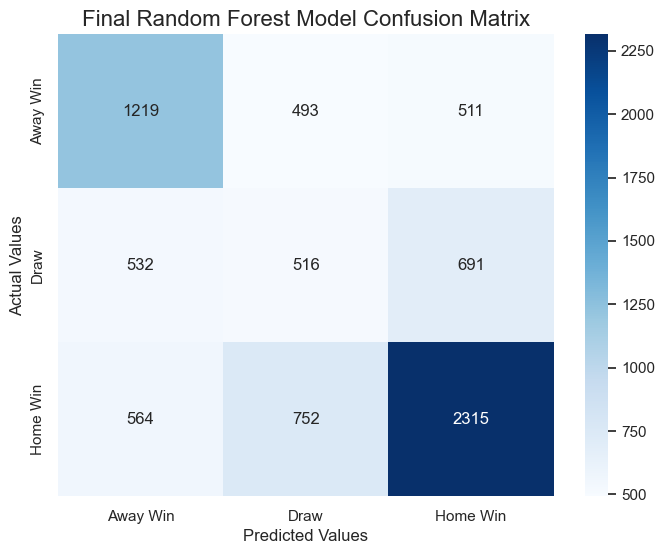


Classification Report:
              precision    recall  f1-score   support

    Away Win       0.53      0.55      0.54      2223
        Draw       0.29      0.30      0.29      1739
    Home Win       0.66      0.64      0.65      3631

    accuracy                           0.53      7593
   macro avg       0.49      0.49      0.49      7593
weighted avg       0.54      0.53      0.53      7593



In [28]:
# --- Final Model Evaluation on the Unseen Test Set ---

# Based on our cross-validation scores, Random Forest (~55% CV accuracy) performed significantly
# better than Logistic Regression (~48% CV accuracy) on the SMOTE-resampled data.
# Therefore, we will select Random Forest as our final, champion model.

# Train the final Random Forest model on the full SMOTE-resampled training data.
final_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
final_model.fit(X_train_smote, y_train_smote_enc)

# Make predictions on the original, unseen test set.
y_pred_final = final_model.predict(X_test)

# --- Define a helper function for plotting the confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Values", fontsize=12)
    plt.ylabel("Actual Values", fontsize=12)
    plt.show()

# --- Display the results for the final Random Forest model ---
print("--- Final Random Forest Model Performance (on Test Set) ---")
print(f"Test Accuracy: {accuracy_score(y_test_enc, y_pred_final):.4f}\n")

# Plot the confusion matrix
plot_confusion_matrix(y_test_enc, y_pred_final, label_encoder.classes_, "Final Random Forest Model Confusion Matrix")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred_final, target_names=label_encoder.classes_))

C:\Users\abdus\AppData\Local\Temp\ipykernel_42972\71352191.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


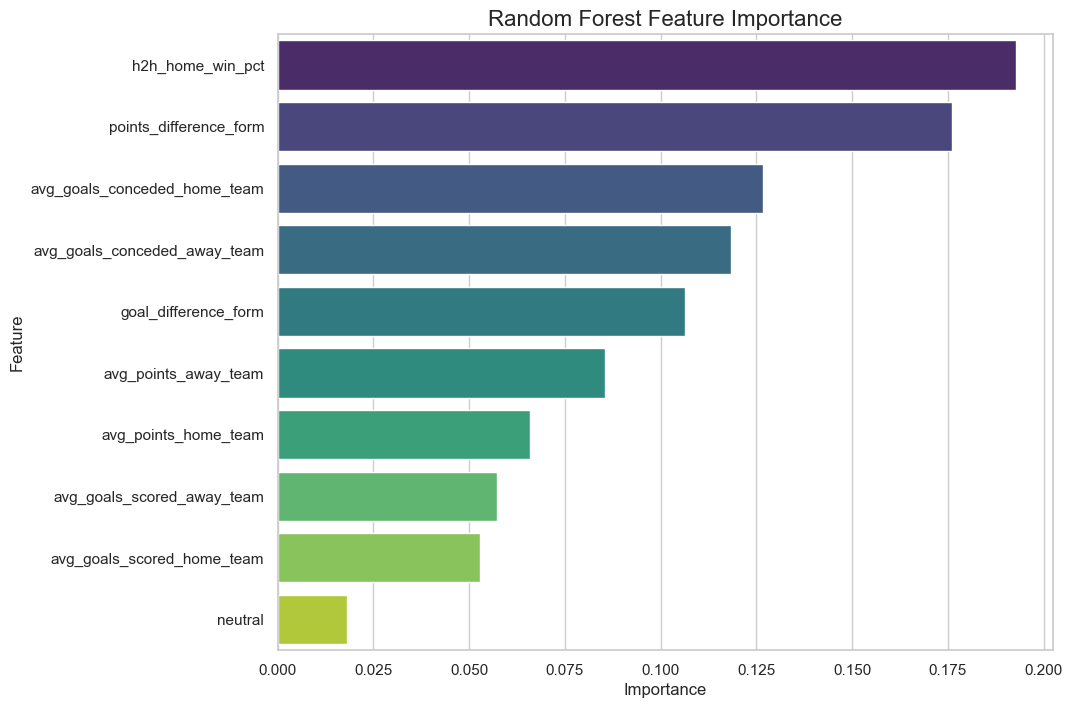

,feature,importance
9,h2h_home_win_pct,0.192654
8,points_difference_form,0.175926
2,avg_goals_conceded_home_team,0.126755
5,avg_goals_conceded_away_team,0.118448
7,goal_difference_form,0.106321
6,avg_points_away_team,0.085552
3,avg_points_home_team,0.066036
4,avg_goals_scored_away_team,0.057239
1,avg_goals_scored_home_team,0.052904
0,neutral,0.018166


In [30]:
# --- Feature Importance Analysis ---
# Answering: "What are the most influential features?"

# Since Random Forest is our final, best-performing model, we will use its feature importance
# metric as our primary piece of evidence. Tree-based models like Random Forest can calculate
# feature importance by measuring how much each feature decreases impurity in the decision trees.

# The model was already trained on SMOTE data in the previous cross-validation cell.
# If you re-ran the final model cell, it's already fitted. If not, fit it again.
if 'final_model' not in locals() or not hasattr(final_model, 'feature_importances_'):
    print("Fitting the Random Forest model for feature importance...")
    final_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    final_model.fit(X_train_smote, y_train_smote_enc)

importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

display(feature_importance_df)

In [31]:
# --- Answering Secondary Question 2: Performance by Tournament ---

# We use our final Random Forest model's predictions to see how its accuracy
# varies between high-stakes World Cup matches and lower-stakes Friendlies.

# Create a copy of the test set to add predictions without warnings
test_data = results.loc[test_idx].copy()
test_data['predicted_outcome'] = label_encoder.inverse_transform(y_pred_final)

# Filter for specific tournaments
wc_matches = test_data[test_data["tournament"] == "FIFA World Cup"]
friendly_matches = test_data[test_data["tournament"] == "Friendly"]

# Calculate accuracy for each tournament using the final model's predictions
wc_accuracy = accuracy_score(wc_matches['outcome'], wc_matches['predicted_outcome'])
friendly_accuracy = accuracy_score(friendly_matches['outcome'], friendly_matches['predicted_outcome'])

print(f"Final Random Forest Model Accuracy on FIFA World Cup matches: {wc_accuracy:.4f}")
print(f"Final Random Forest Model Accuracy on Friendly matches: {friendly_accuracy:.4f}\n")

# You can also view the full classification report for each tournament for more detail
print("--- Classification Report for FIFA World Cup Matches ---")
# Use labels parameter to ensure all classes are shown, even if none were predicted
print(classification_report(wc_matches['outcome'], wc_matches['predicted_outcome'], labels=label_encoder.classes_, target_names=label_encoder.classes_, zero_division=0))

print("\n--- Classification Report for Friendly Matches ---")
print(classification_report(friendly_matches['outcome'], friendly_matches['predicted_outcome'], labels=label_encoder.classes_, target_names=label_encoder.classes_, zero_division=0))

Final Random Forest Model Accuracy on FIFA World Cup matches: 0.4375
Final Random Forest Model Accuracy on Friendly matches: 0.4764

--- Classification Report for FIFA World Cup Matches ---
              precision    recall  f1-score   support

    Away Win       0.48      0.45      0.46        47
        Draw       0.26      0.32      0.29        28
    Home Win       0.53      0.49      0.51        53

    accuracy                           0.44       128
   macro avg       0.42      0.42      0.42       128
weighted avg       0.45      0.44      0.44       128


--- Classification Report for Friendly Matches ---
              precision    recall  f1-score   support

    Away Win       0.40      0.41      0.41       501
        Draw       0.29      0.29      0.29       532
    Home Win       0.61      0.61      0.61      1024

    accuracy                           0.48      2057
   macro avg       0.43      0.43      0.43      2057
weighted avg       0.48      0.48      0.48      20

In [ ]:
# =============================================================================
# CONCLUSION: Predicting International Football Match Outcomes
# =============================================================================

# Summary of Achievements:
# -----------------------------------------------------------------------------
# We successfully built a Random Forest model that predicts match outcomes with
# 53.3% accuracy on unseen test data, representing a 5.5 percentage point
# improvement over the 47.8% baseline. This achievement required addressing the
# critical class imbalance problem using SMOTE, which enabled the model to
# predict all three outcome classes (Home Win, Draw, Away Win) rather than
# ignoring the minority class entirely. Through feature importance analysis, we
# identified the key predictive features: head-to-head win percentage emerged as
# the most influential factor, followed by recent form metrics (points difference
# over last 10 games) and goals conceded averages. Additionally, we discovered
# that model performance varies significantly by tournament type, with friendly
# matches achieving 47.6% accuracy while FIFA World Cup matches dropped to 43.8%
# accuracy, demonstrating that high-stakes tournaments exhibit greater
# unpredictability.

# Key Insights:
# -----------------------------------------------------------------------------
# Historical rivalry matters significantly in predicting match outcomes. Teams
# tend to perform consistently against specific opponents, making head-to-head
# history the strongest predictor in our model. Recent momentum is also crucial,
# as a team's form over their last 10 matches provides valuable signal about
# their current strength. However, draws remain inherently unpredictable even
# with balanced training data, achieving only 29% precision. This suggests that
# draws may be fundamentally more random events influenced by factors beyond
# historical statistics. Finally, context matters tremendously, as the pressure
# and tactical dynamics of World Cup matches make them significantly harder to
# predict than routine friendlies.

# Limitations:
# -----------------------------------------------------------------------------
# The model relies solely on match-level historical data and does not account
# for player-specific factors such as individual player form, injuries,
# suspensions, squad composition, tactical formations, or player market values
# and team quality metrics. External factors are also not captured, including
# weather conditions and pitch quality, travel distance and fixture congestion,
# or coaching changes and team morale. Additionally, the model has limited
# generalizability to other football contexts, as club football may exhibit
# different patterns and different eras of football may have distinct
# characteristics that our model does not capture.

# Future Directions:
# -----------------------------------------------------------------------------
# Future work should incorporate player-level data including individual player
# ratings (such as FIFA ratings or market values), injury and suspension
# information, and key player availability for star players and goalkeepers.
# Adding contextual features would strengthen predictions by accounting for
# weather conditions (temperature, precipitation, wind), venue characteristics
# (altitude, pitch dimensions, crowd capacity), and travel burden with time zone
# changes. Exploring advanced modeling techniques such as deep learning
# approaches (neural networks, LSTMs for sequence data), ensemble methods
# combining multiple model types, and time-aware models that account for the
# evolution of football tactics could improve performance. Developing
# match-specific confidence scores would help identify when the model is most or
# least certain and flag high-uncertainty matches for further analysis. Finally,
# extending to related prediction tasks such as goal difference prediction
# (regression), tournament winner prediction, and player performance forecasting
# would expand the utility of this approach.

# Final Thoughts:
# -----------------------------------------------------------------------------
# This project demonstrates that machine learning can extract meaningful patterns
# from historical football data to predict match outcomes better than chance.
# While our 53.3% accuracy may seem modest, it represents a significant
# achievement given the inherent unpredictability of football, where a single
# moment of brilliance, a refereeing decision, or an unlucky bounce can change
# everything. The beautiful game remains beautifully unpredictable, but data
# science can help us understand the patterns that emerge from chaos.
# =============================================================================